In [143]:
import pandas as pd
import numpy as np
import seaborn as sb
import json
import nltk

from pandas.io.json import json_normalize

%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [144]:
results_df = pd.read_csv('results.csv')
tweets_df = pd.read_csv('FIFA.csv')

In [145]:
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['year'] = results_df['date'].dt.year
results_df['month'] = results_df['date'].dt.month
results_df['monthday'] = results_df['date'].dt.day
results_df['weekday'] = results_df['date'].dt.weekday

## Results

In [146]:
results_df['total_goals'] = results_df['home_score'] + results_df['away_score']
results_df['home_win'] = (results_df['home_score'] > results_df['away_score'])
results_df['away_win'] = (results_df['home_score'] < results_df['away_score'])
#results_df['draw'] = (results_df['home_score'] = results_df['away_score'])
results_df = results_df[results_df['tournament'] != 'Friendly']
results_df = results_df[results_df['year'] > 1994]
results_df['home_win'] = results_df['home_win'].astype(int)
results_df['away_win'] = results_df['away_win'].astype(int)
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,monthday,weekday,total_goals,home_win,away_win
18583,1995-01-06,Japan,Nigeria,0,3,Confederations Cup,Riyadh,Saudi Arabia,True,1995,1,6,4,3,0,1
18584,1995-01-06,Saudi Arabia,Mexico,0,2,Confederations Cup,Riyadh,Saudi Arabia,False,1995,1,6,4,2,0,1
18585,1995-01-07,Senegal,Tunisia,0,0,African Cup of Nations qualification,Ziguinchor,Senegal,False,1995,1,7,5,0,0,0
18586,1995-01-07,Sierra Leone,Gambia,2,0,African Cup of Nations qualification,Freetown,Sierra Leone,False,1995,1,7,5,2,1,0
18587,1995-01-08,Angola,Mozambique,1,0,African Cup of Nations qualification,Luanda,Angola,False,1995,1,8,6,1,1,0


In [147]:
results_df['tournament'].value_counts().head(10)

FIFA World Cup qualification            4618
UEFA Euro qualification                 1409
African Cup of Nations qualification    1041
AFC Asian Cup qualification              508
CFU Caribbean Cup qualification          414
FIFA World Cup                           381
African Cup of Nations                   378
CECAFA Cup                               372
Island Games                             308
COSAFA Cup                               272
Name: tournament, dtype: int64

In [148]:
results_df['year'].value_counts().head(10)

2001    755
2015    725
2011    701
2004    687
2008    682
1997    654
2000    650
2007    645
2013    641
2016    633
Name: year, dtype: int64

In [149]:
agg_home = {'home_score':'sum','away_score':'sum','home_team':'count','home_win':'sum'}
agg_away = {'away_score':'sum','home_score':'sum','away_team':'count','away_win':'sum'}
home_agg_df = results_df.groupby('home_team').agg(agg_home)
away_agg_df = results_df.groupby('away_team').agg(agg_away)
home_agg_df = home_agg_df[home_agg_df['home_team'] > 59]
away_agg_df = away_agg_df[away_agg_df['away_team'] > 59]

In [150]:
home_agg_df['goal_dif'] = home_agg_df['home_score'] - home_agg_df['away_score']
home_agg_df['mean_goal_dif'] = home_agg_df['goal_dif']/home_agg_df['home_team']
home_agg_df['winning_pct'] = home_agg_df['home_win']/home_agg_df['home_team']
home_agg_df.sort_values('mean_goal_dif',ascending = False).head(10)

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
home_team,,,,,,,
Australia,333,61,91,70,272,2.989011,0.769231
Spain,242,49,89,68,193,2.168539,0.764045
Netherlands,212,49,84,61,163,1.940476,0.726190
Iran,243,53,105,71,190,1.809524,0.676190
Portugal,201,54,86,59,147,1.709302,0.686047
Germany,255,90,104,72,165,1.586538,0.692308
England,164,43,78,51,121,1.551282,0.653846
Brazil,273,87,120,87,186,1.550000,0.725000
Syria,163,63,65,36,100,1.538462,0.553846


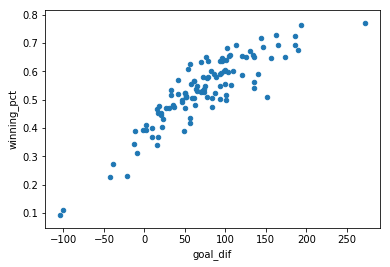

In [151]:
home_agg_df.plot.scatter('goal_dif','winning_pct')

In [152]:
away_agg_df['goal_dif'] = away_agg_df['away_score'] - away_agg_df['home_score']
away_agg_df['mean_goal_dif'] = away_agg_df['goal_dif']/away_agg_df['away_team']
away_agg_df['winning_pct'] = away_agg_df['away_win']/away_agg_df['away_team']
away_agg_df.sort_values('mean_goal_dif',ascending = False).head(10)

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
away_team,,,,,,,
Germany,179,66,79,56,113,1.430380,0.708861
Spain,171,62,86,58,109,1.267442,0.674419
England,140,53,77,45,87,1.129870,0.584416
Iran,175,78,91,45,97,1.065934,0.494505
Japan,168,81,87,50,87,1.000000,0.574713
Netherlands,131,65,69,42,66,0.956522,0.608696
Brazil,147,76,80,37,71,0.887500,0.462500
Portugal,146,72,84,44,74,0.880952,0.523810
France,111,57,72,40,54,0.750000,0.555556


In [153]:
home_agg_df.corr()

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
home_score,1.000000,0.107806,0.795709,0.917119,0.918144,0.765822,0.706483
away_score,0.107806,1.000000,0.446452,-0.003370,-0.294957,-0.516370,-0.513938
home_team,0.795709,0.446452,1.000000,0.842112,0.586823,0.318832,0.359607
home_win,0.917119,-0.003370,0.842112,1.000000,0.882798,0.712753,0.794596
goal_dif,0.918144,-0.294957,0.586823,0.882798,1.000000,0.941851,0.883849
mean_goal_dif,0.765822,-0.516370,0.318832,0.712753,0.941851,1.000000,0.913303
winning_pct,0.706483,-0.513938,0.359607,0.794596,0.883849,0.913303,1.000000


In [154]:
away_agg_df.corr()

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
away_score,1.000000,-0.455442,0.624720,0.940619,0.871251,0.849656,0.859762
home_score,-0.455442,1.000000,0.030682,-0.584264,-0.833780,-0.839205,-0.719616
away_team,0.624720,0.030682,1.000000,0.595553,0.370504,0.395711,0.321667
away_win,0.940619,-0.584264,0.595553,1.000000,0.905451,0.887230,0.944852
goal_dif,0.871251,-0.833780,0.370504,0.905451,1.000000,0.989599,0.929932
mean_goal_dif,0.849656,-0.839205,0.395711,0.887230,0.989599,1.000000,0.915692
winning_pct,0.859762,-0.719616,0.321667,0.944852,0.929932,0.915692,1.000000


In [155]:
competetive_dif = away_agg_df['mean_goal_dif'] + home_agg_df['mean_goal_dif']
competetive_dif.sort_values(ascending=False).head(10)

Australia      3.446154
Spain          3.435981
Germany        3.016918
Netherlands    2.896998
Iran           2.875458
England        2.681152
Portugal       2.590255
Brazil         2.437500
France         2.190860
China          2.088283
Name: mean_goal_dif, dtype: float64

In [156]:
competitive_win_pct = (away_agg_df['winning_pct'] + home_agg_df['winning_pct'])/2
competitive_win_pct.sort_values(ascending=False).head(10)

Spain             0.719232
Germany           0.700584
Netherlands       0.667443
England           0.619131
France            0.605735
Portugal          0.604928
Brazil            0.593750
Italy             0.587970
Czech Republic    0.587491
Iran              0.585348
Name: winning_pct, dtype: float64

In [172]:
home_agg_df.describe()

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
count,166.00000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,108.39759,64.138554,62.596386,31.704819,44.259036,0.623672,0.489097
std,51.26259,22.684371,19.086717,16.058329,55.816901,0.842173,0.145116
min,8.00000,23.000000,32.000000,0.000000,-173.000000,-3.604167,0.000000
25%,67.00000,49.000000,50.000000,20.000000,12.500000,0.231121,0.410633
50%,102.00000,60.000000,59.000000,29.000000,44.500000,0.717806,0.503521
75%,135.00000,74.750000,73.000000,41.000000,76.500000,1.167795,0.580342
max,289.00000,181.000000,125.000000,90.000000,232.000000,2.900000,0.762500


In [173]:
away_agg_df.describe()

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,65.950820,93.688525,58.240437,17.442623,-27.737705,-0.635734,0.281194
std,32.625797,32.325376,15.687088,11.482224,53.795778,1.124166,0.145709
min,5.000000,39.000000,31.000000,0.000000,-256.000000,-6.129032,0.000000
25%,42.000000,71.000000,44.500000,9.000000,-53.500000,-1.115476,0.179029
50%,61.000000,88.000000,59.000000,15.000000,-28.000000,-0.514286,0.278689
75%,87.000000,108.500000,70.000000,24.500000,6.000000,0.100541,0.376974
max,173.000000,261.000000,109.000000,53.000000,100.000000,1.492537,0.731343


# 1998 and Beyond

In [157]:
modern_era_df = results_df[results_df['year']>1997]
modern_era_df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,monthday,weekday,total_goals,home_win,away_win
20915,1998-01-10,Malawi,Zambia,0,1,COSAFA Cup,Blantyre,Malawi,False,1998,1,10,5,1,0,1
20923,1998-01-18,Lesotho,Zimbabwe,0,2,COSAFA Cup,Maseru,Lesotho,False,1998,1,18,6,2,0,1
20928,1998-01-24,Namibia,South Africa,3,2,COSAFA Cup,Windhoek,Namibia,False,1998,1,24,5,5,1,0
20930,1998-01-25,Botswana,Mozambique,1,2,COSAFA Cup,Gaborone,Botswana,False,1998,1,25,6,3,0,1
20931,1998-01-25,Thailand,Egypt,1,1,King's Cup,Bangkok,Thailand,False,1998,1,25,6,2,0,0
20932,1998-01-27,Egypt,Korea Republic,0,2,King's Cup,Bangkok,Thailand,True,1998,1,27,1,2,0,1
20936,1998-01-28,Iran,Nigeria,0,1,Lunar New Year Cup,So Kon Po,Hong Kong,True,1998,1,28,2,1,0,1
20941,1998-01-29,Thailand,Korea Republic,0,2,King's Cup,Bangkok,Thailand,False,1998,1,29,3,2,0,1
20944,1998-01-31,Egypt,Korea Republic,1,1,King's Cup,Bangkok,Thailand,True,1998,1,31,5,2,0,0
20945,1998-01-31,Iran,Chile,1,1,Lunar New Year Cup,So Kon Po,Hong Kong,True,1998,1,31,5,2,0,0


In [158]:
agg_home = {'home_score':'sum','away_score':'sum','home_team':'count','home_win':'sum'}
agg_away = {'away_score':'sum','home_score':'sum','away_team':'count','away_win':'sum'}
home_agg_df = modern_era_df.groupby('home_team').agg(agg_home)
away_agg_df = modern_era_df.groupby('away_team').agg(agg_away)
home_agg_df = home_agg_df[home_agg_df['home_team'] > 30]
away_agg_df = away_agg_df[away_agg_df['away_team'] > 30]

In [159]:
home_agg_df['goal_dif'] = home_agg_df['home_score'] - home_agg_df['away_score']
home_agg_df['mean_goal_dif'] = home_agg_df['goal_dif']/home_agg_df['home_team']
home_agg_df['winning_pct'] = home_agg_df['home_win']/home_agg_df['home_team']
home_agg_df.sort_values('mean_goal_dif',ascending = False).head(10)

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
home_team,,,,,,,
Australia,289,57,80,61,232,2.900000,0.762500
Fiji,122,31,36,23,91,2.527778,0.638889
New Caledonia,115,34,35,21,81,2.314286,0.600000
Spain,216,45,79,60,171,2.164557,0.759494
Netherlands,190,47,76,55,143,1.881579,0.723684
New Zealand,111,39,40,29,72,1.800000,0.725000
Portugal,186,50,77,52,136,1.766234,0.675325
Iran,201,44,91,64,157,1.725275,0.703297
China,177,52,73,42,125,1.712329,0.575342


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a452db9e8>]],
      dtype=object)

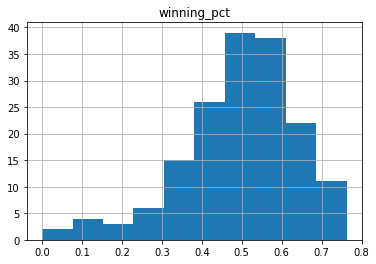

In [160]:
home_agg_df.hist('winning_pct')

In [161]:
away_agg_df['goal_dif'] = away_agg_df['away_score'] - away_agg_df['home_score']
away_agg_df['mean_goal_dif'] = away_agg_df['goal_dif']/away_agg_df['away_team']
away_agg_df['winning_pct'] = away_agg_df['away_win']/away_agg_df['away_team']
away_agg_df.sort_values('mean_goal_dif',ascending = False).head(10)

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
away_team,,,,,,,
Germany,156,56,67,49,100,1.492537,0.731343
Spain,153,55,76,53,98,1.289474,0.697368
England,132,53,72,41,79,1.097222,0.569444
Netherlands,109,55,58,36,54,0.931034,0.620690
New Caledonia,101,66,39,15,35,0.897436,0.384615
Japan,139,72,75,44,67,0.893333,0.586667
Portugal,129,65,73,41,64,0.876712,0.561644
Brazil,128,68,69,31,60,0.869565,0.449275
Czech Republic,119,62,70,41,57,0.814286,0.585714


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28ec35f8>]],
      dtype=object)

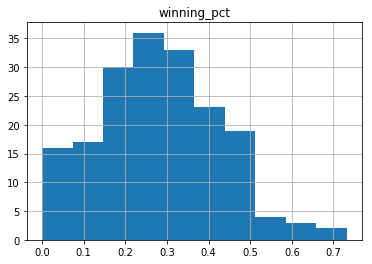

In [162]:
away_agg_df.hist('winning_pct')

In [163]:
home_agg_df.corr()

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
home_score,1.000000,0.011569,0.806369,0.935328,0.913704,0.743867,0.746516
away_score,0.011569,1.000000,0.351641,-0.047038,-0.395781,-0.606586,-0.537984
home_team,0.806369,0.351641,1.000000,0.863495,0.597665,0.326675,0.395593
home_win,0.935328,-0.047038,0.863495,1.000000,0.878128,0.680961,0.787366
goal_dif,0.913704,-0.395781,0.597665,0.878128,1.000000,0.929692,0.904246
mean_goal_dif,0.743867,-0.606586,0.326675,0.680961,0.929692,1.000000,0.914829
winning_pct,0.746516,-0.537984,0.395593,0.787366,0.904246,0.914829,1.000000


In [167]:
m0 = smf.ols(formula = 'winning_pct ~ home_score',data=home_agg_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            winning_pct   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     206.4
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           7.96e-31
Time:                        19:46:00   Log-Likelihood:                 153.01
No. Observations:                 166   AIC:                            -302.0
Df Residuals:                     164   BIC:                            -295.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2600      0.018     14.752      0.000       0.225       0.295
home_score     0.0021      0.000     14.368      0.000       0.002       0.002
==============================================================================
Omnibus:                        6.611   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.336
Skew:                          -0.468   Prob(JB):                       0.0421
Kurtosis:                       3.202   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
m0 = smf.ols(formula = 'winning_pct ~ away_score',data=home_agg_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            winning_pct   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     66.80
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           7.74e-14
Time:                        19:46:19   Log-Likelihood:                 113.73
No. Observations:                 166   AIC:                            -223.5
Df Residuals:                     164   BIC:                            -217.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7098      0.029     24.787      0.000       0.653       0.766
away_score    -0.0034      0.000     -8.173      0.000      -0.004      -0.003
==============================================================================
Omnibus:                        0.227   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.339
Skew:                           0.079   Prob(JB):                        0.844
Kurtosis:                       2.846   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
away_agg_df.corr()

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
away_score,1.000000,-0.371981,0.740842,0.945992,0.829995,0.808512,0.862802
home_score,-0.371981,1.000000,0.009250,-0.442334,-0.826488,-0.776341,-0.625215
away_team,0.740842,0.009250,1.000000,0.739103,0.443744,0.529560,0.468834
away_win,0.945992,-0.442334,0.739103,1.000000,0.839515,0.802123,0.920803
goal_dif,0.829995,-0.826488,0.443744,0.839515,1.000000,0.956838,0.898954
mean_goal_dif,0.808512,-0.776341,0.529560,0.802123,0.956838,1.000000,0.855785
winning_pct,0.862802,-0.625215,0.468834,0.920803,0.898954,0.855785,1.000000


In [169]:
m1 = smf.ols(formula = 'winning_pct ~ home_score',data=away_agg_df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            winning_pct   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     116.2
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           3.07e-21
Time:                        19:46:29   Log-Likelihood:                 138.68
No. Observations:                 183   AIC:                            -273.4
Df Residuals:                     181   BIC:                            -266.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5452      0.026     21.045      0.000       0.494       0.596
home_score    -0.0028      0.000    -10.778      0.000      -0.003      -0.002
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.163
Skew:                           0.185   Prob(JB):                        0.559
Kurtosis:                       3.125   Cond. No.                         305.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
m0 = smf.ols(formula = 'winning_pct ~ away_score',data=away_agg_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            winning_pct   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     527.2
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           1.64e-55
Time:                        19:46:53   Log-Likelihood:                 218.15
No. Observations:                 183   AIC:                            -432.3
Df Residuals:                     181   BIC:                            -425.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0271      0.012      2.193      0.030       0.003       0.051
away_score     0.0039      0.000     22.961      0.000       0.004       0.004
==============================================================================
Omnibus:                        2.712   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.419
Skew:                           0.164   Prob(JB):                        0.298
Kurtosis:                       3.458   Cond. No.                         166.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
away_agg_df.describe()

,away_score,home_score,away_team,away_win,goal_dif,mean_goal_dif,winning_pct
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,65.950820,93.688525,58.240437,17.442623,-27.737705,-0.635734,0.281194
std,32.625797,32.325376,15.687088,11.482224,53.795778,1.124166,0.145709
min,5.000000,39.000000,31.000000,0.000000,-256.000000,-6.129032,0.000000
25%,42.000000,71.000000,44.500000,9.000000,-53.500000,-1.115476,0.179029
50%,61.000000,88.000000,59.000000,15.000000,-28.000000,-0.514286,0.278689
75%,87.000000,108.500000,70.000000,24.500000,6.000000,0.100541,0.376974
max,173.000000,261.000000,109.000000,53.000000,100.000000,1.492537,0.731343


In [175]:
home_agg_df.describe()

,home_score,away_score,home_team,home_win,goal_dif,mean_goal_dif,winning_pct
count,166.00000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,108.39759,64.138554,62.596386,31.704819,44.259036,0.623672,0.489097
std,51.26259,22.684371,19.086717,16.058329,55.816901,0.842173,0.145116
min,8.00000,23.000000,32.000000,0.000000,-173.000000,-3.604167,0.000000
25%,67.00000,49.000000,50.000000,20.000000,12.500000,0.231121,0.410633
50%,102.00000,60.000000,59.000000,29.000000,44.500000,0.717806,0.503521
75%,135.00000,74.750000,73.000000,41.000000,76.500000,1.167795,0.580342
max,289.00000,181.000000,125.000000,90.000000,232.000000,2.900000,0.762500


In [130]:
competetive_dif = away_agg_df['mean_goal_dif'] + home_agg_df['mean_goal_dif']
competetive_dif.sort_values(ascending=False).head(10)

Spain            3.454031
Australia        3.375410
New Caledonia    3.211722
Germany          3.051677
Netherlands      2.812613
England          2.724088
Portugal         2.642946
Iran             2.462117
Brazil           2.280780
France           2.165960
Name: mean_goal_dif, dtype: float64

In [131]:
competitive_win_pct = (away_agg_df['winning_pct'] + home_agg_df['winning_pct'])/2
competitive_win_pct.sort_values(ascending=False).head(10)

Spain             0.728431
Germany           0.709758
Netherlands       0.672187
France            0.622923
England           0.620543
Portugal          0.618484
Czech Republic    0.605357
Italy             0.592105
Iran              0.581912
New Zealand       0.578716
Name: winning_pct, dtype: float64

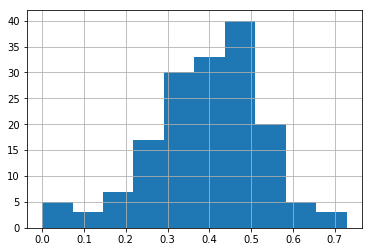

In [132]:
competitive_win_pct.hist()

# Tweets

In [133]:
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
tweets_df['year'] = tweets_df['Date'].dt.year
tweets_df['month'] = tweets_df['Date'].dt.month
tweets_df['monthday'] = tweets_df['Date'].dt.day
tweets_df['weekday'] = tweets_df['Date'].dt.weekday
tweets_df['hour'] = tweets_df['Date'].dt.hour

In [134]:
tweets_df.head()

,ID,lang,Date,Source,len,Orig_Tweet,Tweet,Likes,RTs,Hashtags,...,UserMentionID,Name,Place,Followers,Friends,year,month,monthday,weekday,hour
0,1013597060640145408,en,2018-07-02 01:35:45,Twitter for Android,140,RT @Squawka: Only two goalkeepers have saved t...,Only two goalkeepers have saved three penaltie...,0,477,"WorldCup,POR,ENG",...,Squawka,Cayleb,Accra,861,828,2018,7,2,0,1
1,1013597056219295744,en,2018-07-02 01:35:44,Twitter for Android,139,RT @FCBarcelona: ?? @ivanrakitic scores the wi...,scores the winning penalty to send into the qu...,0,1031,WorldCup,...,"FCBarcelona,ivanrakitic,HNS_CFF",Febri Aditya,Bogor,667,686,2018,7,2,0,1
2,1013597047482544130,en,2018-07-02 01:35:42,Twitter for Android,107,RT @javierfernandez: Tonight we have big game....,Tonight we have big game,0,488,worldcup,...,"javierfernandez,EvgeniPlushenko",??,NaN,65,67,2018,7,2,0,1
3,1013597044198391808,en,2018-07-02 01:35:41,Twitter Web Client,142,We get stronger\r\nTurn the music up now\r\nWe...,We get stronger Turn the music up now We got t...,0,0,"PowerByEXO,WorldCup,FIFAStadiumDJ,XiuminLeague",...,"weareoneEXO,FIFAWorldCup",Frida Carrillo,"Zapopan, Jalisco",17,89,2018,7,2,0,1
4,1013597039999926272,en,2018-07-02 01:35:40,Twitter for Android,140,RT @Squawka: Only two goalkeepers have saved t...,Only two goalkeepers have saved three penaltie...,0,477,"WorldCup,POR,ENG",...,Squawka,tar,NaN,137,216,2018,7,2,0,1


In [135]:
tweets_df['lang'].value_counts()

en    530000
Name: lang, dtype: int64

In [136]:
tweets_df['month'].min()

6

In [137]:
agg_d = {'Likes':['sum','mean'],
         'RTs':['sum','mean'],
         'len':'mean'}

tweets_agg_df = tweets_df.groupby(['month','monthday','hour']).agg(agg_d)

In [138]:
tweets_agg_df

Likes                   RTs                       len
                        sum      mean         sum          mean        mean
month monthday hour                                                        
6     29       23        89  0.183128      839200   1726.748971  129.061728
      30       0       2207  0.272536    15958964   1970.729069  127.711657
               1        745  0.116116    13056058   2034.921758  129.683915
               16     53885  1.281847    33876929    805.883603  126.577729
               17      6922  0.385348    13639646    759.318933  128.092802
               23      4213  0.574997    13563215   1851.128020  125.855466
7     1        0       2350  0.224344    17904813   1709.290024  126.666253
               1       2022  0.228011    14065429   1586.088069  127.004962
               2        424  0.127327     4678810   1405.048048  128.648649
               20     98972  3.683776    12048204    448.438754  105.700450
               21     49492  1.761720    30773375   1095.410778  126.812480
               22     12360  0.893839    20048712   1449.863465  123.907217
               23      5881  0.649117    14684119   1620.763687  119.744812
      2        0       2748  0.344750    10642948   1335.208631  123.012796
               1       1162  0.277924     5162680   1234.795503  125.070557
      3        22     28998  1.449900    43253819   2162.690950  120.709500
      4        15      4213  0.693955    12793644   2107.337177  130.367155
               16      3434  0.384590    15224961   1705.113787  131.992944
      10       15      8277  0.551800    28169197   1877.946467  134.848867
               17     14807  0.987133    18299691   1219.979400  127.254667
               18     14830  0.988667     8756081    583.738733  113.535133
               20      6104  0.439960    20042469   1444.606386  124.420210
               21       174  0.154529     1451626   1289.188277  127.514210
               22      7894  0.592242    27815147   2086.814240  122.247205
               23        99  0.059246     4174610   2498.270497  125.693597
      11       19     33724  1.124133    12150195    405.006500  103.678867
               21      5093  0.339533    22527747   1501.849800  128.012733
      15       4        925  0.425679     3976572   1829.991717  125.196963
               5       2577  0.469998     9659539   1761.725150  125.855189
               6       6475  0.916101    10727423   1517.745190  125.756225
               7         34  0.123188      256465    929.221014  141.634058
               17    205556  1.974962  1169880607  11240.097684  120.516444
               18     27865  0.606829   370840028   8075.960452  121.389381
               22      1093  0.170435   197744717  30834.978481  128.000000
               23       595  0.069291   267208798  31117.829044  128.187493